Predict number of rented bikes using ARIMA and ARIMAX

In [4]:
from tbats import TBATS, BATS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import residuals_plot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
import pmdarima as pm
from skforecast.model_selection_statsmodels import grid_search_sarimax

df1=pd.read_csv('day.csv', parse_dates=['dteday'])
df1

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Drop some unnecessary data

In [5]:
df1=df1.drop(['instant','casual'], axis=1)

Plot histograms

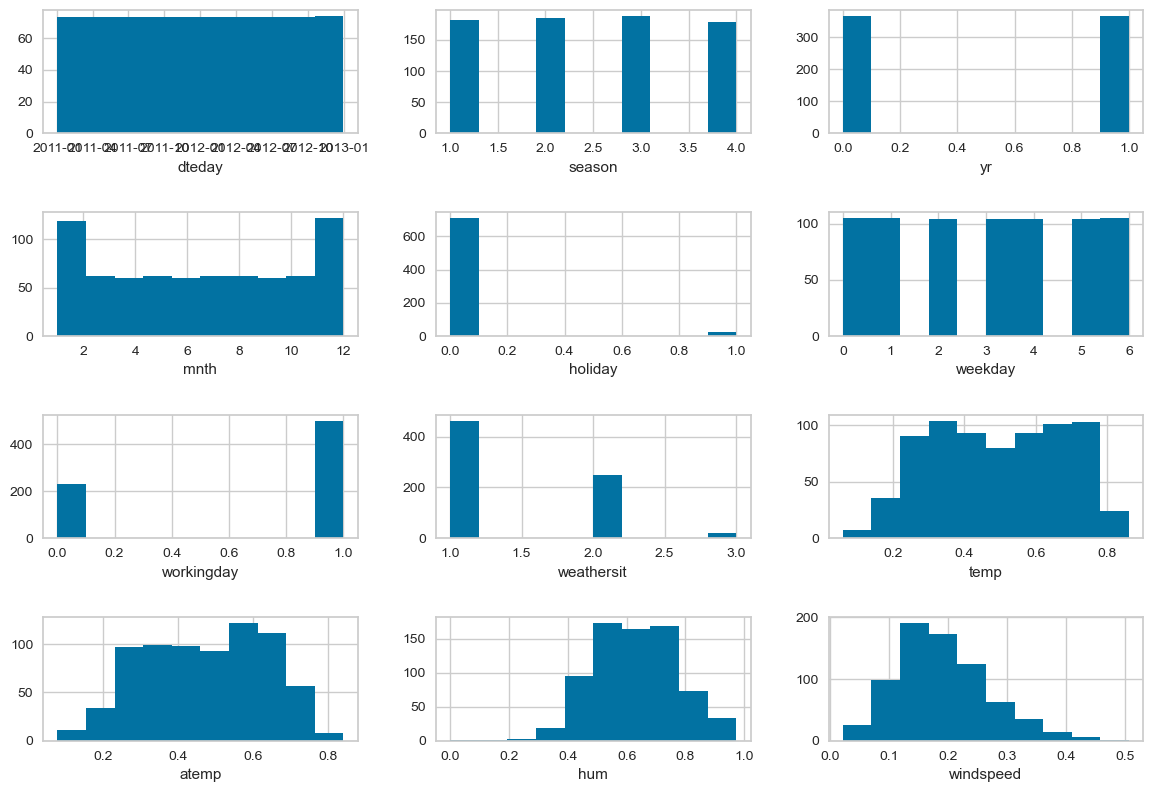

In [6]:
fig=plt.figure(figsize=(12,10))
count=0
for i in range(4):
    for j in range(3):
        plt.subplot2grid((5,3),(i,j))
        plt.hist(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1


Plot box

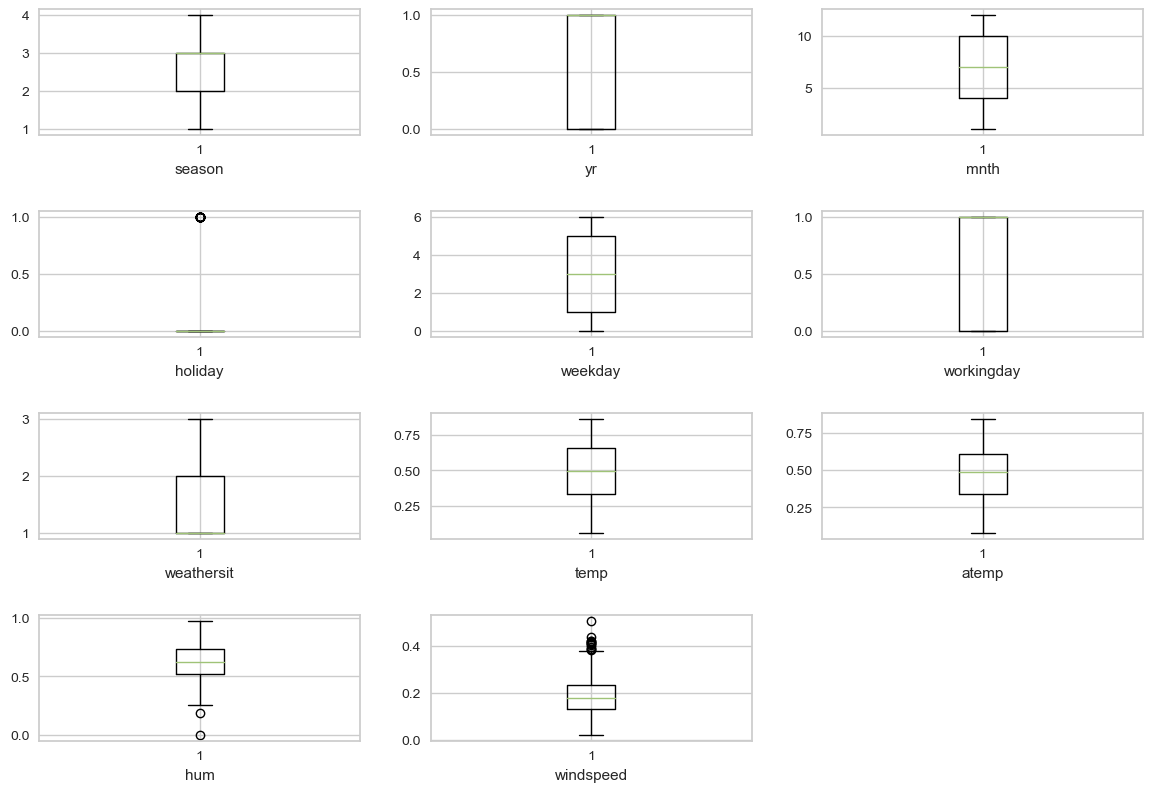

In [7]:
fig=plt.figure(figsize=(12,10))
count=1
for i in range(4):
    for j in range(3):
        if count== 12:
            break
        plt.subplot2grid((5,3),(i,j))
        plt.boxplot(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1

Check if there is any duplicated data

In [8]:
df1.duplicated().sum()

0

Check if there is any nun value

In [9]:
df1.isna().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
registered    0
cnt           0
dtype: int64

In [10]:
df1['dteday'].describe()

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_37167/916621911.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1['dteday'].describe()


count                     731
unique                    731
top       2011-01-01 00:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-31 00:00:00
Name: dteday, dtype: object

I select the train to be from the first of 2011 till first of May 2012 and the rest of months of 2021 serves as test dataset

In [11]:
df1=df1.set_index('dteday')

In [12]:
df1

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered,cnt
dteday,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,654,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,670,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1229,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1454,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,1867,2114
2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,2451,3095
2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1182,1341


Plot the time series to see any trend or seasonality

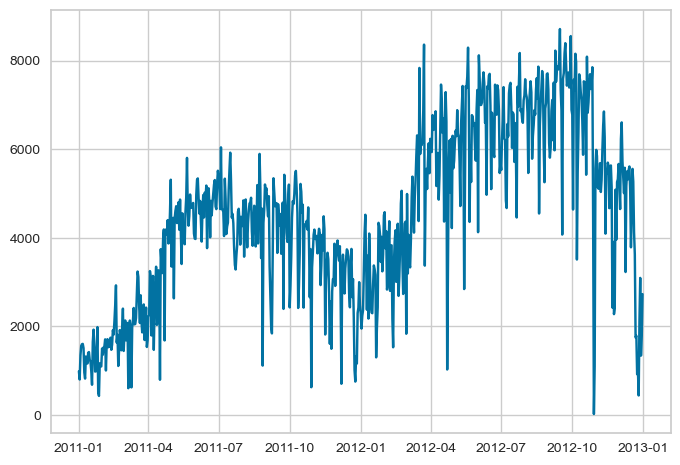

In [13]:
plt.plot(df1['cnt'])

There is a yearly and weekly seasonality. 

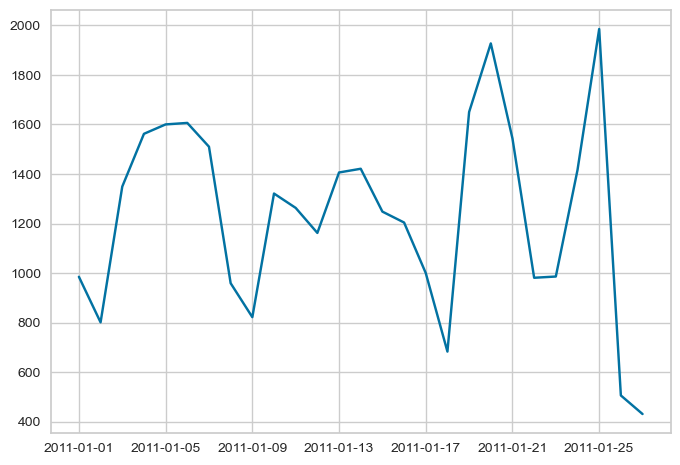

In [14]:
c=df1[df1.index < '2011-01-28']
plt.plot(c['cnt'])

Plot ACF and PACF

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


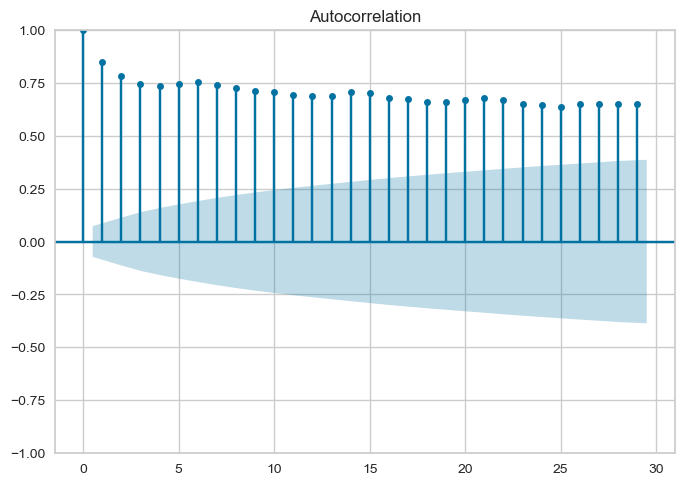

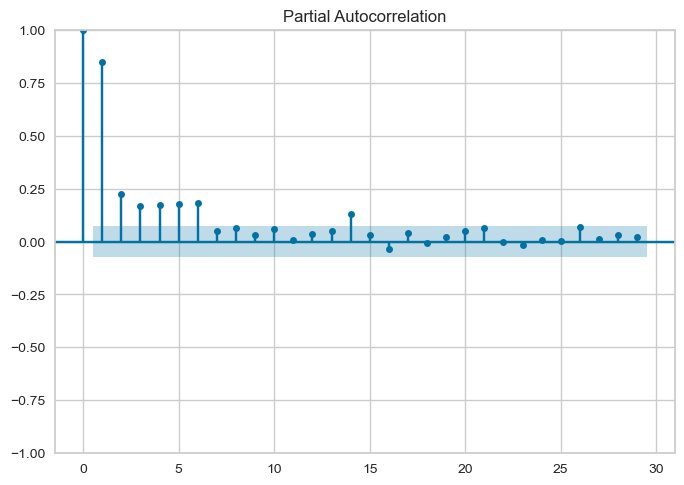

In [15]:
acf_df1=plot_acf(df1['cnt'])
pacf_df1=plot_pacf(df1['cnt'])

Make the stationary test using ADF

In [16]:
result=adfuller(df1.cnt)
print('P-value: ',result[1])

P-value:  0.3427434403392201


Since p is larger than significant value (0.05), null hypothesis is valid (time series is non-stationary). Let's make the time series stationary and then look at the ACF and PACF again

In [17]:
df1_a=df1.diff().dropna()

check the stazionarity of time series

In [18]:
result=adfuller(df1_a.cnt)
print('P-value: ',result[1])


P-value:  1.0467797548019514e-21


So p value is smaller than significant value (0.05), therefore time series is stationary. So with one differencing , time series becomes stationary (d=1). Plot ACF and PACF again for the stationary time series.

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


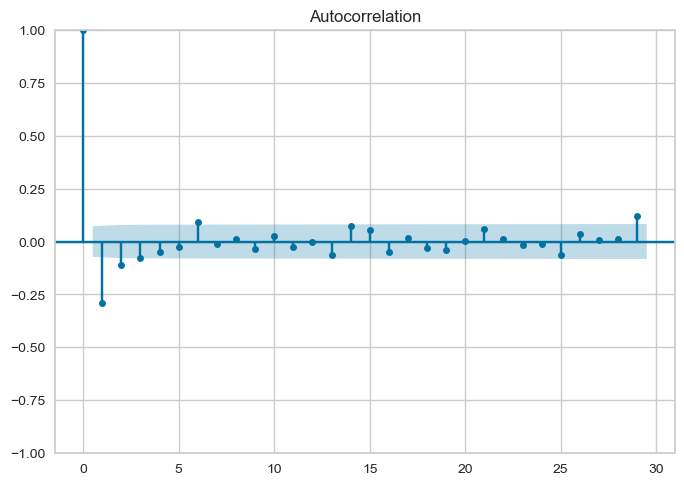

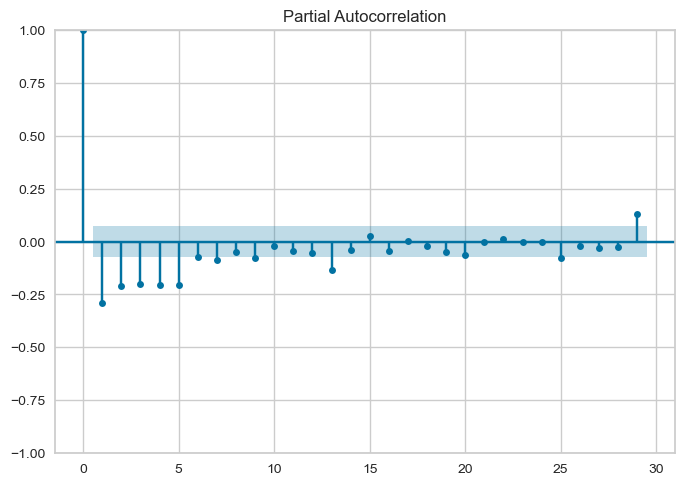

In [19]:
acf_df1_a=plot_acf(df1_a['cnt'])
pacf_df1_a=plot_pacf(df1_a['cnt'])

First split the data to train and test

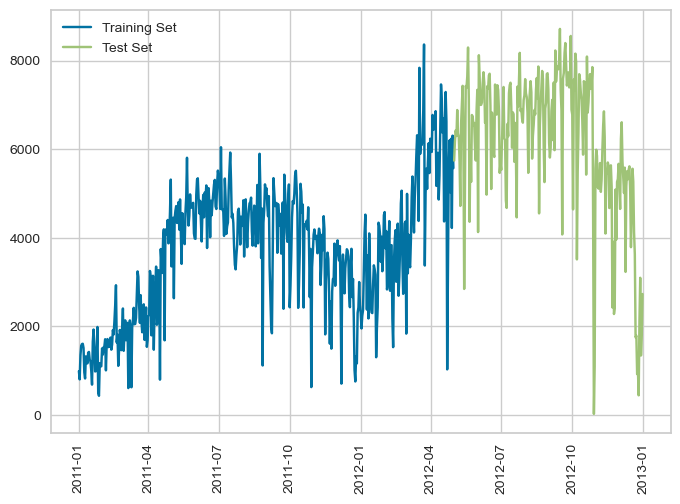

In [20]:
train=df1[df1.index < '05-01-2012']
test= df1[df1.index >= '05-01-2012']
plt.plot(train.index, train['cnt'])
plt.plot(test.index, test['cnt'])
plt.xticks(rotation=90)
plt.legend(['Training Set', 'Test Set'])

plt.show()

Plotting cross-validation 

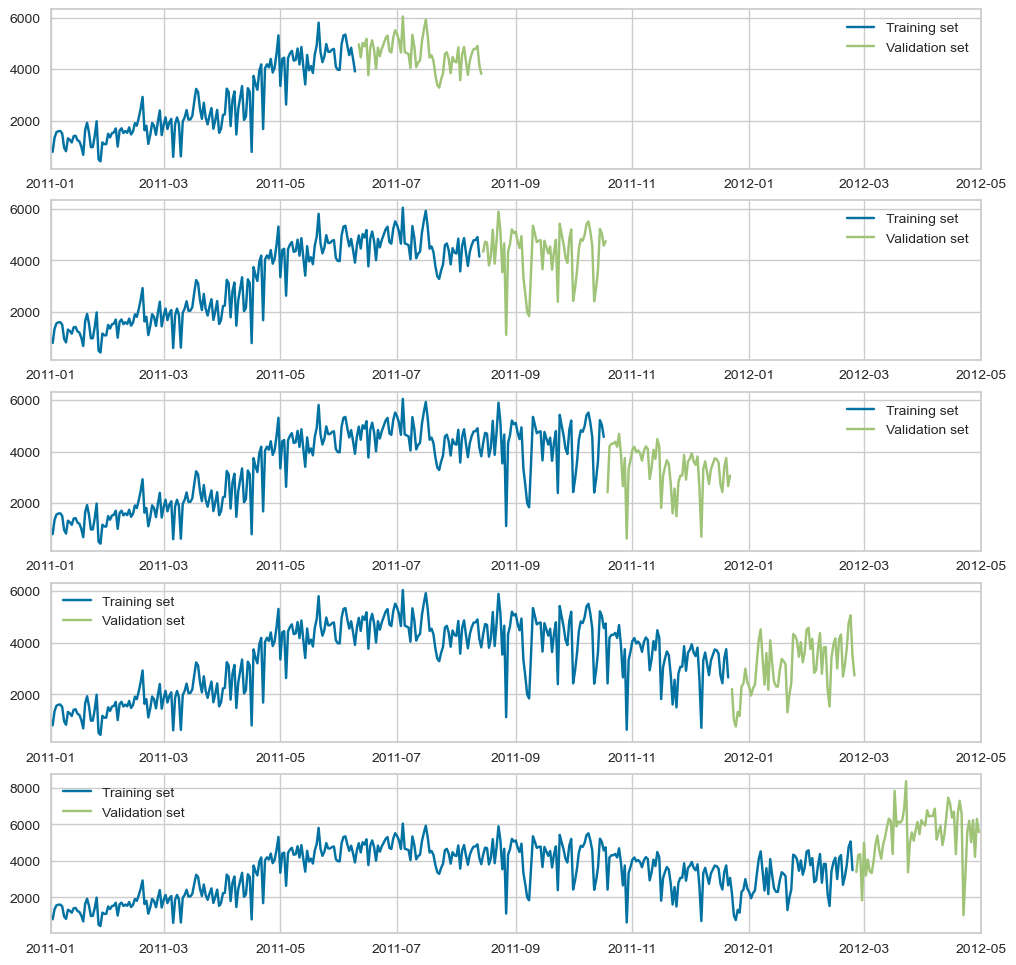

In [21]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()
fig=plt.figure(figsize=(12,12))

count=0
for train_in, val_in in cross_val.split(train):
    train_valid=df1.iloc[train_in]
    validation=df1.iloc[val_in]
    plt.subplot2grid((5,1),(count,0))
    plt.plot(train_valid.index, train_valid['cnt'])
    plt.plot(validation.index,validation['cnt'])
    plt.legend(['Training set','Validation set'])
    plt.xlim([dt.date(2011, 1, 1), dt.date(2012, 5, 1)])
    count+=1

plt.show()

Define x and y and fit the model 

In [27]:
import warnings
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()
warnings.filterwarnings("ignore") # specify to ignore warning messages

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    y_train=train_valid.drop(['cnt','registered','atemp','hum'], axis=1)
    x_val=validation['cnt']

    estimator = TBATS(seasonal_periods=(7, 365))
    model = estimator.fit(x_train)
    # Forecast 365 days ahead
    print(model.summary())

    print('##############################################################################')
    print('##################################   END   ###################################')
    print('##############################################################################')





/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in recipr

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 365.]
Seasonal harmonics [1 7]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): -0.010000
Seasonal Parameters (Gamma): [ 1.30556230e-08  2.21649716e-08 -1.23716142e-09  1.79092246e-08]
AR coefficients []
MA coefficients []
Seed vector [-2.86271221e+07  5.21089696e+01 -3.03068906e+01  1.04566636e+07
  3.51810467e+07 -1.30275968e+07 -7.29877950e+06  3.11974679e+06
  2.98661598e+05 -1.01841945e+05  5.07716377e+07 -1.51323851e+07
 -1.86767061e+07  7.69159231e+06  1.94352533e+06 -8.03223224e+05
 -1.59712764e+04]

AIC 2850.113863
##############################################################################
##################################   END   ###################################
##############################################################################


/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in recipr

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 365.]
Seasonal harmonics [1 9]
ARMA errors (p, q): (2, 0)
Smoothing (Alpha): -0.012101
Seasonal Parameters (Gamma): [ 0.01850015  0.00796047 -0.01306623  0.00569453]
AR coefficients [-0.01306623  0.00569453]
MA coefficients []
Seed vector [-7.45573486e+05  5.85141590e+01 -2.11379534e+01 -5.13738423e+05
  8.82240743e+05  8.03458409e+05 -5.11467216e+04 -3.24851762e+05
 -1.01687332e+05  3.19191081e+04  1.91339381e+04  1.11619392e+03
  1.31971686e+06  8.06053776e+05 -3.97024286e+05 -5.89510417e+05
 -9.65653090e+04  1.28978502e+05  5.63894012e+04 -2.26452985e+03
 -3.39146554e+03  0.00000000e+00  0.00000000e+00]

AIC 4057.653421
##############################################################################
##################################   END   ###################################
##############################################################################


/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in recipr

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 365.]
Seasonal harmonics [1 7]
ARMA errors (p, q): (2, 1)
Smoothing (Alpha): -0.005192
Seasonal Parameters (Gamma): [ 2.20849593e-05 -5.46938395e-06 -1.29412094e-05  2.11949634e-06]
AR coefficients [-1.29412094e-05  2.11949634e-06]
MA coefficients [0.26167267]
Seed vector [ 3.22783931e+03  5.18032918e+01  3.38092572e+01 -1.63517775e+03
 -1.84021372e+02 -5.50034632e+01 -7.31620839e-01  2.90505869e+01
  6.53130766e+01 -1.34991976e+02 -5.59847909e+02 -3.10056273e+02
  2.69801923e+02  3.30707673e+01 -1.46424270e+02 -1.09306707e+02
  3.71041963e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00]

AIC 5442.007618
##############################################################################
##################################   END   ###################################
##############################################################################


/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in recipr

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (2, 3)
Smoothing (Alpha): 0.109260
Seasonal Parameters (Gamma): []
AR coefficients [-0.23481115 -0.38211414]
MA coefficients [0.51845585 0.52456151 0.19601918]
Seed vector [1264.57602462    0.            0.            0.            0.
    0.        ]

AIC 6768.707171
##############################################################################
##################################   END   ###################################
##############################################################################


/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in recipr

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (2, 1)
Smoothing (Alpha): 0.187886
Seasonal Parameters (Gamma): []
AR coefficients [ 1.06413093 -0.28940558]
MA coefficients [-0.81211666]
Seed vector [1264.57602462    0.            0.            0.        ]

AIC 8089.725435
##############################################################################
##################################   END   ###################################
##############################################################################


Plot residuals

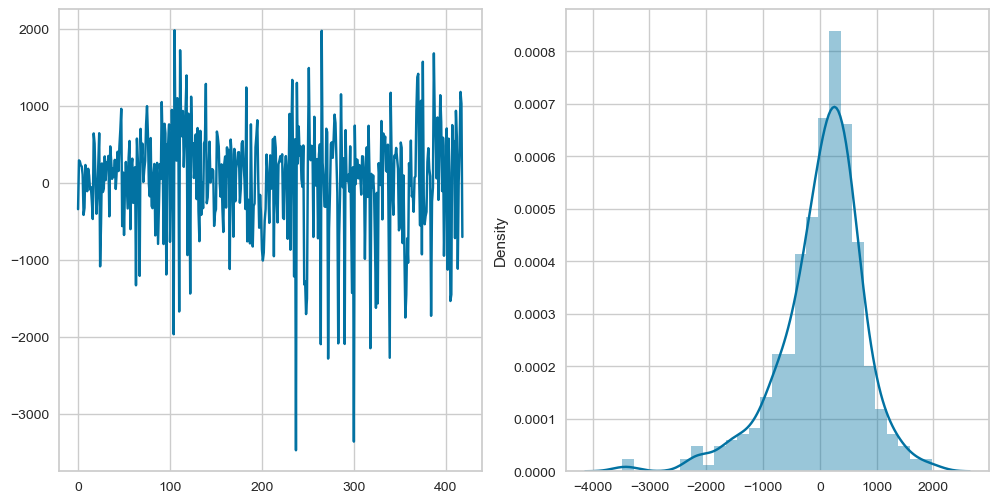

In [56]:
residuals = model.resid[1:]
fig=plt.figure(figsize=(12,6))
plt.subplot2grid((1,2),(0,0))
plt.plot(residuals )
plt.subplot2grid((1,2),(0,1))

sns.distplot(residuals)
plt.show()

In [61]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt','registered','atemp','hum'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt','registered','atemp','hum'], axis=1)
estimator = TBATS(seasonal_periods=(7, 365))
model = estimator.fit(x_train)

print(model.summary())

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in recipr

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (2, 1)
Smoothing (Alpha): 0.187886
Seasonal Parameters (Gamma): []
AR coefficients [ 1.06413093 -0.28940558]
MA coefficients [-0.81211666]
Seed vector [1264.57602462    0.            0.            0.        ]

AIC 8089.725435


Plot prediction and observation

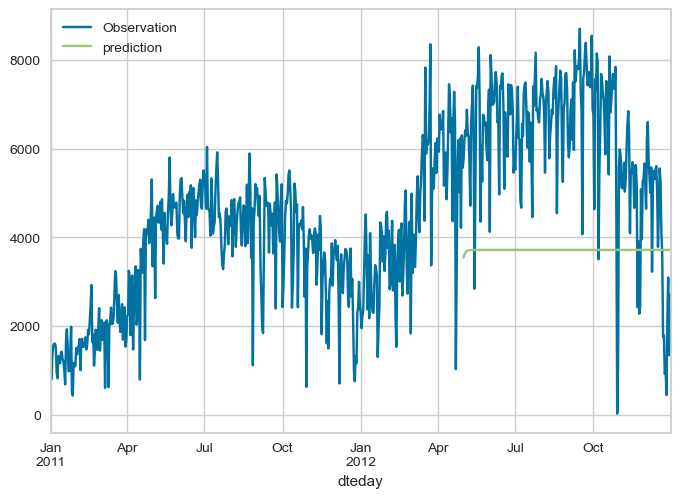

In [62]:
forecast_test = model.forecast(len(x_test))
df1['forecast_manual'] = [None]*len(x_train_total) + list(forecast_test)
df1['cnt'].plot()
df1['forecast_manual'].plot()
plt.legend(['Observation','prediction'])


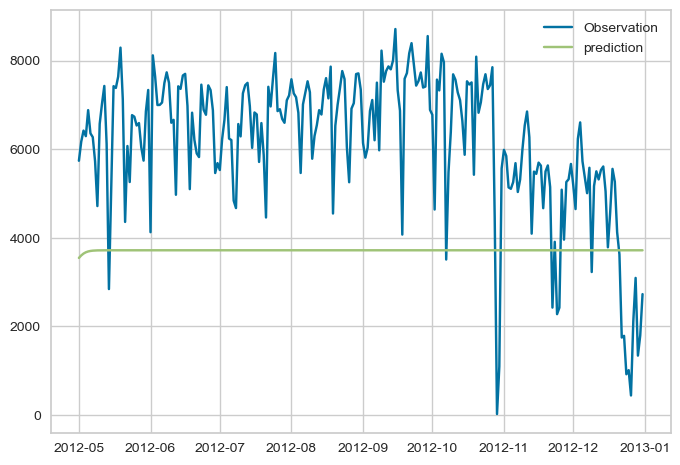

In [76]:
plt.plot(x_test)
plt.plot(df1['forecast_manual'].dropna() )
plt.legend(['Observation','prediction'])

In [66]:
print('Mean absolute error is: ',mean_absolute_error(x_test, df1['forecast_manual'].dropna()))
print('Rsquare is: ',r2_score(x_test, df1['forecast_manual'].dropna()))

Mean absolute error is:  2711.8126261130146
Rsquare is:  -2.3200409203849364


Let's make it multivariate

In [81]:
from sktime.registry import all_estimators

for forecaster in all_estimators(filter_tags={"scitype:y": ["multivariate", "both"]}):
    print(forecaster[0])

KeyboardInterrupt: 

In [96]:
import warnings
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()
warnings.filterwarnings("ignore") # specify to ignore warning messages

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    y_train=train_valid.drop(['cnt','registered','atemp','hum'], axis=1)
    x_val=validation['cnt']
    tt=train.drop(['cnt','registered','atemp','hum'], axis=1)

    estimator = TBATS(seasonal_periods=(7, 365))
    model = estimator.fit(tt,)
    # Forecast 365 days ahead
    print(model.summary())

InputArgsException: y series is invalid